In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import string
import re
import nltk
#from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer
#from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report

In [5]:
text_df = pd.read_csv('data.csv', header=0, index_col=0)
text_df

,product_type,description
0,lip_liner,Lippie Pencil A long-wearing and high-intensit...
1,lipstick,Blotted Lip Sheer matte lipstick that creates ...
2,lipstick,"Lippie Stix Formula contains Vitamin E, Mango,..."
3,foundation,"Developed for the Selfie Age, our buildable fu..."
4,lipstick,All of our products are free from lead and hea...
...,...,...
926,mascara,You will fall in love with Pacifica's long las...
927,mascara,Physicians Formula Organic Wear FakeOut Mascar...
928,mascara,Physicians Formula Organic Wear Lash Boosting ...
929,mascara,Voluminous - Volume Building Waterproof Mascar...


In [6]:
#missing values:
text_df.isnull().sum()

product_type    0
description     0
dtype: int64

In [7]:
text_df['description'][3]

'Developed for the Selfie Age, our buildable full coverage, natural matte foundation delivers flawless looking skin from day-to-night. The oil-free, lightweight formula blends smoothly and is easily customizable to create the coverage you want. Build it up or sheer it out, it was developed with innovative soft-blurring pigments to deliver true color while looking and feeling natural. The lockable pump is easy to use and keeps your routine mess-free! As always, 100% cruelty-free and vegan.'

In [8]:
#Converting Description from Object to String
text_df['description'] = text_df['description'].astype(str)

In [9]:
#Spliting Text to words
print(text_df['description'].apply(lambda x: len(x.split(' '))).sum())

94257


In [10]:
#Removing Null (NAN) Values
text_df.dropna(subset=['description'], inplace=True)

In [11]:
text_df.isnull().sum()

product_type    0
description     0
dtype: int64

In [12]:
#Added a length column -> length of description
text_df['length'] = text_df['description'].apply(len)
text_df.head()

,product_type,description,length
0,lip_liner,Lippie Pencil A long-wearing and high-intensit...,232
1,lipstick,Blotted Lip Sheer matte lipstick that creates ...,146
2,lipstick,"Lippie Stix Formula contains Vitamin E, Mango,...",188
3,foundation,"Developed for the Selfie Age, our buildable fu...",492
4,lipstick,All of our products are free from lead and hea...,357


In [13]:
text_df.product_type.unique()

array(['lip_liner', 'lipstick', 'foundation', 'eyeliner', 'eyeshadow',
       'blush', 'bronzer', 'mascara', 'eyebrow', 'nail_polish'],
      dtype=object)

In [17]:
#merging classes into superclasses
text_df.loc[text_df['product_type'].isin(['lipstick','lip_liner']),'product_type'] = 'lipstick'
text_df.loc[text_df['product_type'].isin(['blush','bronzer']),'product_type'] = 'contour'
text_df.loc[text_df['product_type'].isin(['eyeliner','eyeshadow','mascara','eyebrow']),'product_type'] = 'eye_makeup'

In [18]:
text_df.product_type.value_counts()

eye_makeup     367
lipstick       176
foundation     159
contour        144
nail_polish     60
Name: product_type, dtype: int64

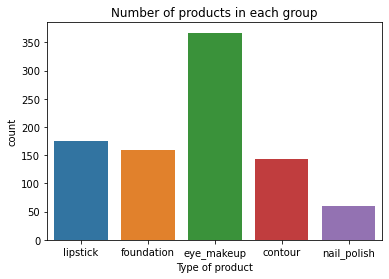

In [19]:
sns.countplot(x='product_type',data=text_df)
plt.xlabel('Type of product')
plt.title('Number of products in each group');

In [33]:
#Text Pre rocessing
nltk.download('stopwords')
stop = stopwords.words('english')
print(stop[::10])

porter = nltk.stem.PorterStemmer()
print('done')

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]
done


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aymane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
def remove_punctuation(description):
    """The function to remove punctuation"""
    table = str.maketrans('', '', string.punctuation)
    return description.translate(table)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [35]:
text_df['description'] = text_df['description'].apply(remove_punctuation)
text_df['description'] = text_df['description'].apply(remove_stopwords)
text_df['description'] = text_df['description'].apply(stemmer)

In [36]:
text_df.head()

,product_type,description,length
0,lipstick,lippi pencil longwear highintens lip pencil gl...,232
1,lipstick,blot lip sheer matt lipstick creat perfect pop...,146
2,lipstick,lippi stix formula contain vitamin e mango avo...,188
3,foundation,develop selfi age buildabl full coverag natur ...,492
4,lipstick,product free lead heavi metal paraben phthalat...,357


In [37]:
text_df['description'][1]

'blot lip sheer matt lipstick creat perfect popsicl pout formula lightweight matt buildabl light medium coverag'

In [40]:
vectorizer = CountVectorizer()
vectorizer.fit(text_df['description'])
vector = vectorizer.transform(text_df['description'])
print(vector.shape)
print(vector.toarray())

(906, 5891)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [41]:
# extract the tfid representation matrix of the text data
tfidf_converter = TfidfTransformer()
X_tfidf = tfidf_converter.fit_transform(vector).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
X = text_df['description']
y = text_df['product_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((679,), (227,), (679,), (227,))

In [43]:
#Logistic Regression
model_log = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                      ('tfidf', TfidfTransformer()),
                      ('model',LogisticRegression()),
                     ])

model_log.fit(X_train, y_train)

ytest = np.array(y_test)
pred = model_log.predict(X_test)

In [44]:
print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.9295154185022027
              precision    recall  f1-score   support

     contour       0.89      0.86      0.88        37
  eye_makeup       0.93      0.99      0.96        98
  foundation       0.89      0.89      0.89        28
    lipstick       0.95      0.91      0.93        46
 nail_polish       1.00      0.83      0.91        18

    accuracy                           0.93       227
   macro avg       0.93      0.90      0.91       227
weighted avg       0.93      0.93      0.93       227



In [45]:
#SVM - Support Vector Machine
nbc = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('model',MultinomialNB()),
               ])

nbc.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = nbc.predict(X_test)

In [46]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.8898678414096917
              precision    recall  f1-score   support

     contour       0.93      0.76      0.84        37
  eye_makeup       0.86      0.99      0.92        98
  foundation       0.83      0.86      0.84        28
    lipstick       0.95      0.87      0.91        46
 nail_polish       1.00      0.72      0.84        18

    accuracy                           0.89       227
   macro avg       0.91      0.84      0.87       227
weighted avg       0.90      0.89      0.89       227



In [48]:
#Random Forest
rf = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('rf', RandomForestClassifier(n_estimators=50)),
               ])

rf.fit(X_train, y_train)

ytest = np.array(y_test)
preds = rf.predict(X_test)

In [58]:
print('accuracy %s' % accuracy_score(preds, y_test))
print(classification_report(ytest, preds))

accuracy 0.920704845814978
              precision    recall  f1-score   support

     contour       0.82      0.86      0.84        37
  eye_makeup       0.93      0.97      0.95        98
  foundation       0.88      0.79      0.83        28
    lipstick       0.98      0.91      0.94        46
 nail_polish       1.00      1.00      1.00        18

    accuracy                           0.92       227
   macro avg       0.92      0.91      0.91       227
weighted avg       0.92      0.92      0.92       227



In [59]:
#Naive Bayes
nbc = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('model',MultinomialNB()),
               ])

nbc.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = nbc.predict(X_test)

In [60]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.8898678414096917
              precision    recall  f1-score   support

     contour       0.93      0.76      0.84        37
  eye_makeup       0.86      0.99      0.92        98
  foundation       0.83      0.86      0.84        28
    lipstick       0.95      0.87      0.91        46
 nail_polish       1.00      0.72      0.84        18

    accuracy                           0.89       227
   macro avg       0.91      0.84      0.87       227
weighted avg       0.90      0.89      0.89       227



In [61]:
#best model
log_acc = accuracy_score(pred, y_test)
svm_acc = accuracy_score(pred_y, y_test)
rf_acc = accuracy_score(preds, y_test)
nb_acc = accuracy_score(pred_y, y_test)


In [62]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'SVM', 'Naive Bayes', 'Random Forest'],
                      'Score': [log_acc, svm_acc, nb_acc, rf_acc,]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Logistic Regression,0.929515
3,Random Forest,0.920705
1,SVM,0.889868
2,Naive Bayes,0.889868
